In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from torch import Tensor
from torch.autograd import Variable

# pyro functions we probably won't use to get w and b

In [3]:
mu = Variable(Tensor([0.]))
sigma = Variable(Tensor([1.23]))
get_w = lambda: dist.normal(mu, sigma).data[0]
get_b = lambda: dist.normal(mu, sigma).data[0]

# yeah let's just generate some lines with identity covariance matrix

In [4]:
mu = np.zeros(2)
x = np.linspace(-10, 10, 200)


def plot_lines(cov, mu=mu, ylim=(-25, 25)):
    
    # Set up figure
    plt.figure(figsize=(10, 6))
    plt.ylim(*ylim)
    plt.xlim(-10, 10)

    for _ in range(100):

        # Draw bias weight
        bias, weight = np.random.multivariate_normal(mu, cov)
        
        # Compute function output
        y = weight * x + bias
        
        plt.plot(x, y)

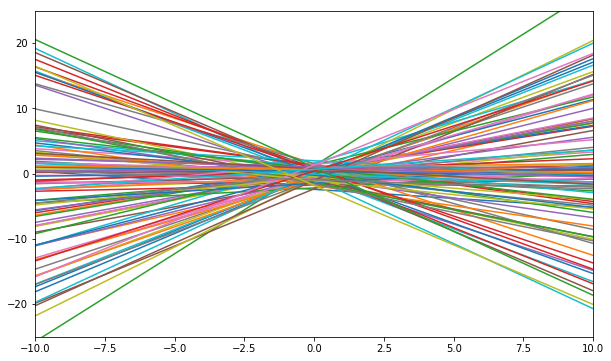

In [4]:
plot_lines(cov=np.eye(2))

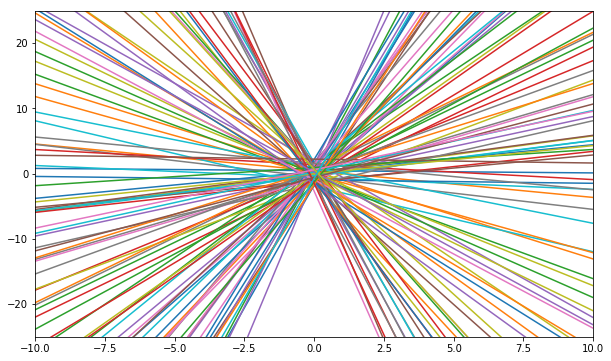

In [5]:
plot_lines(cov=np.diag([1, 30]))

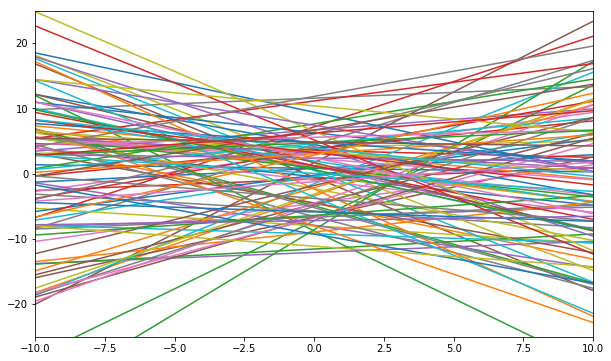

In [6]:
plot_lines(cov=np.diag([30, 1]))

# Define some crazy function

In [7]:
y_true = np.sin(x)**2 - np.abs(x - 3) + 7
y_true_ = y_true + .5 * np.random.randn(len(y_true))

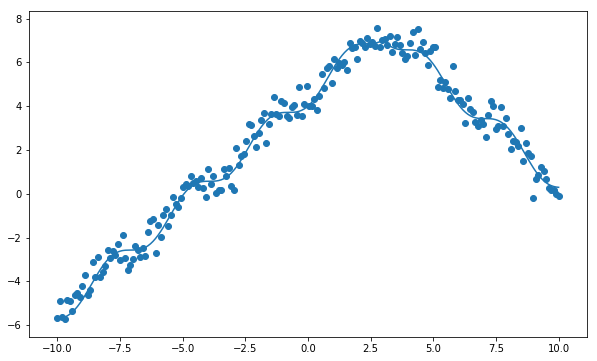

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y_true)
plt.scatter(x, y_true_)

# gaussian processes

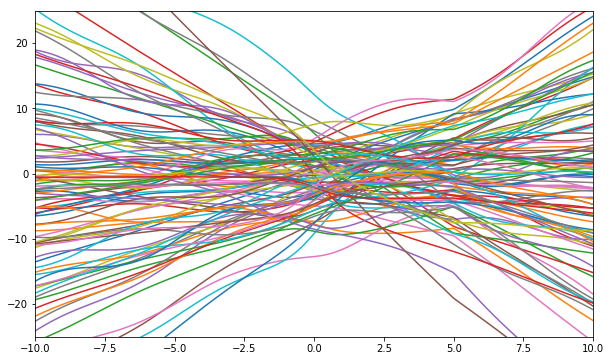

In [40]:
# weights
mu_w = np.zeros(5)
cov_w = np.diag(np.exp(np.random.randn(5)))


# features
features = np.array([np.ones_like(x), x, np.tanh(x), -np.cos(x), np.abs(x - 5)])


# define mean func
def mean_func(features, w):
    return np.zeros(features.shape[1])


def plot_function_evals(mu_w, cov_w, features, n_samples=100, mean_func=mean_func):
    plt.figure(figsize=(10, 6))
    plt.ylim(-25, 25)
    plt.xlim(-10, 10)

    for _ in range(n_samples):
        w = np.random.multivariate_normal(mu_w, cov_w)
        mu_y = mean_func(features, w)
        cov_y = features.T @ cov_w @ features
        y = np.random.multivariate_normal(mu_y, cov_y)
        plt.plot(x, y)
    return mu_y, cov_y
        
_ = plot_function_evals(mu_w, cov_w, features)

/Users/willwolf/anaconda3/envs/pyro/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: covariance is not positive-semidefinite.


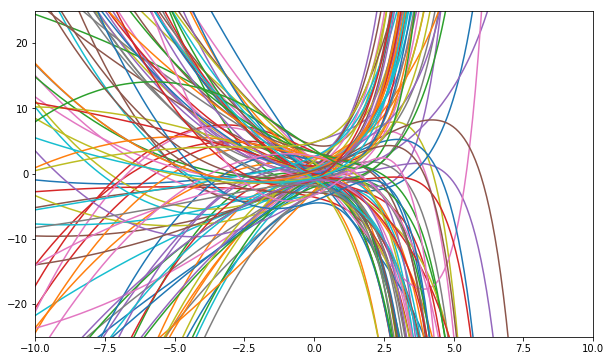

In [41]:
features = np.array([np.exp(x), x - 1, x, x**2, 1.2345*np.ones_like(x)])

_ = plot_function_evals(mu_w, cov_w, features)

# RBF

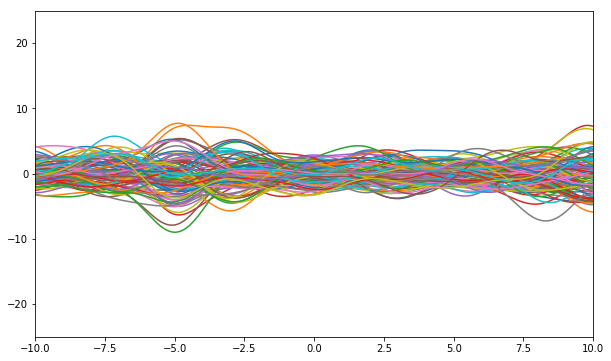

In [42]:
D = BIG_NUMBER = 198

mu_w = np.zeros(D)
cov_w = np.diag(np.exp(np.random.randn(D)))
features = np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])

_ = plot_function_evals(mu_w, cov_w, features)

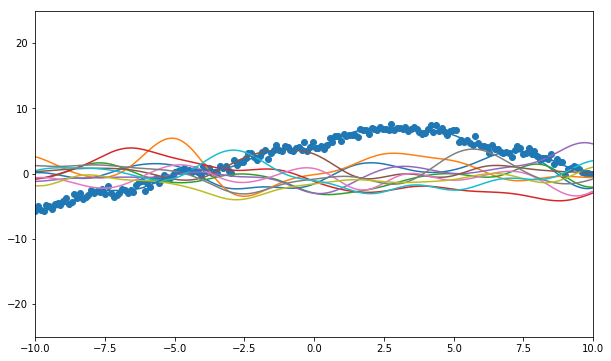

In [43]:
_ = plot_function_evals(mu_w, cov_w, features, n_samples=10)

plt.plot(x, y_true)
plt.scatter(x, y_true_)

# This whole covariance business

In [44]:
# D = 7
# N_OBS = 12

# mu_w = np.random.randn(D)

# 1. we can just make this ourselves:
#    - how does each of the 7 dimensions covary with every other dimension?
#    - for this reason, the thing will always be of size 7 x 7
# 2. we can estimate this from data
#    - numpy docs say: "m : array_like; A 1-D or 2-D array containing multiple variables 
#      and observations. Each row of m represents a variable, and each column a single 
#      observation of all those variables."
#    - this is backwards from what we typically think. nonetheless, our input to np.cov
#      should be of size (D, N_OBS)

# cov_w = np.cov(np.random.randn(D, N_OBS))

# N_OBS_X = 100

# mu_y = np.random.randn(N_OBS_X)  # after passing it through the mean function, which collapses the dimensionality D to 1
# phi_x = np.random.randn(D, N_OBS_X)  # same as above, with D first then N_OBS_X
# cov_y = phi_x.T @ cov_w @ phi_x  # 100 x 100; # we often just compute this directly with RBF kernel; this is the explicit way, which is of course infeasible if `phi` gives inf features!

# # now pluck out your things
# cov_w_y = cov_w @ phi_x  # (7 x 7) @ (7, 100) --> 7, 100
# cov_y_x = phi_x.T @ cov_w  # (100 x 7) @ (7, 7) --> 100, 7

# Posterior distributions

# $P(w\vert y)$

In [140]:
# x, y_true = zip(*[(xx, np.sin(xx) + np.abs(3 - xx)) for xx in [-1, 3, 7, 9, 12]])
x, y_true = zip(*[(xx, np.sin(xx)) for xx in [-5, -1, 3, 7, 9, 12]])

x = np.array(x)
y_true = np.array(y_true)

In [144]:
# start to finish

D = BIG_NUMBER = 198

# prior over weights
mu_w = np.zeros(D)
cov_w = np.diag(np.exp(np.random.randn(D)))

# features
features = np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])

# prior over function evaluations
# this is really just a thing that computes w^T x; whenever we see w^T x, we use this
# one of these instances is: in the formula for `mu_w_post`
mu_y = mean_func(features, w="doesn't matter")
cov_y = features.T @ cov_w @ features

# posterior over weight distribution
mu_w_post = mu_w + cov_w @ features @ np.linalg.inv(cov_y) @ (y_true - mu_y)
cov_w_post = cov_w - cov_w @ features @ np.linalg.inv(cov_y) @ features.T @ cov_w

# new features
x_new = np.linspace(-15, 15, 500)
features = np.array([np.exp(-.5 * (x_new - d)**2) for d in range(int(-D / 2), int(D / 2))])

# posterior over function evaluations
# THIS IS DIFFERENT THAN YOUR MEAN FUNC; THIS IS THE GAUSSIANS BEING CLOSED UNDER LINEAR MAPS
mu_y_post = features.T @ mu_w_post

cov_y_post = features.T @ cov_w_post @ features

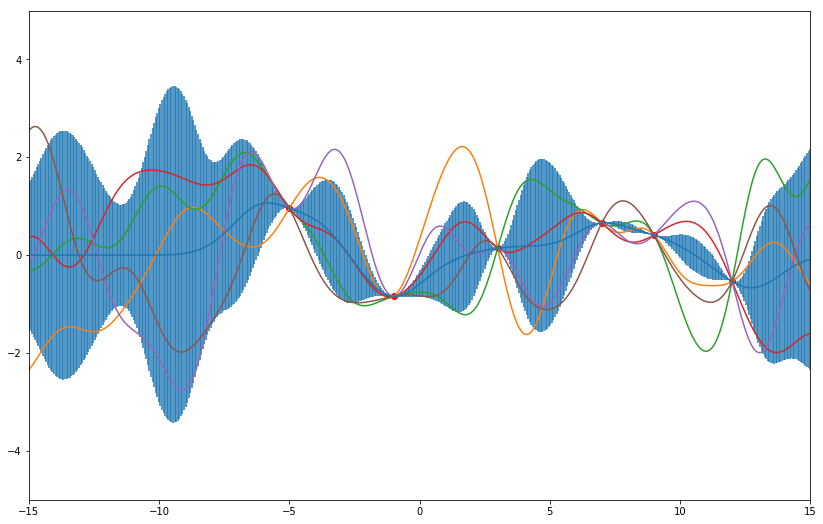

In [163]:
plt.figure(figsize=(14, 9))
plt.ylim(-5, 5)
plt.xlim(-15, 15)

plt.errorbar(x_new, mu_y_post, yerr=np.diag(cov_y_post), capsize=0)
plt.plot(x, y_true, 'ro')
for _ in range(5):
    y = np.random.multivariate_normal(mu_y_post, cov_y_post)
    plt.plot(x_new, y)

In [112]:
x_train = np.array([-5, -1, -2.5, 2, 4, 6])
y_train = np.sin(x_train) - np.abs(x_train - 3) + 5

x_test = np.linspace(-10, 10, 200)

In [113]:
def rbf(a, b, c=1, l=1):
    a = np.expand_dims(a, 1)  # dims: (len(x), 1)
    b = np.expand_dims(b, 0)  # dims: (1, len(b))
    # a - b --> dims: (len(x), len(b))
    return np.exp(c * -.5 * ((a - b) / l)**2)

In [114]:
cov_obs = 0 * \
    np.eye(len(x_train))

A = rbf(x_test, x_train) @ np.linalg.inv(rbf(x_train, x_train) + cov_obs)
mu_post  = A @ y_train
cov_post = rbf(x_test, x_test) - A @ rbf(x_train, x_test)

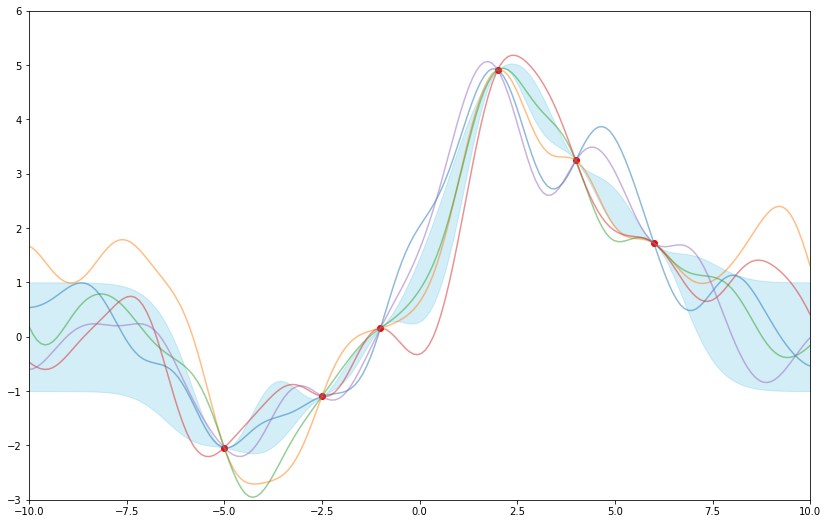

In [121]:
plt.figure(figsize=(14, 9))
plt.ylim(-3, 6)
plt.xlim(-10, 10)

var_post = np.diag(cov_post)
plt.fill_between(x_test, mu_post - var_post, mu_post + var_post, color='#23AEDB', alpha=.2)
plt.plot(x_train, y_train, 'ro')
for _ in range(5):
    y_pred = np.random.multivariate_normal(mu_post, cov_post)
    plt.plot(x_test, y_pred, alpha=.5)

In [ ]:
# You should dive into kernels and compute the whole thing more analytically and get a few results

In [ ]:
# try the above with just 5 ground-truth data points, then evaluate over whole x-axis
# try to do this analytically with RBF kernels. plot 1 draw from the prior (with mean-0) function, along with the error bar. all draws from this prior should be the same.
# cross-reference the more general formula for the conditional gaussian.

In [ ]:
# ok, doing this analytically

"Centering the process on a linear model, while allowing the process to accommodate deviations from the lienar model, addresses the curse of dimensionality, as the psoterior can concentrate close to the linear moel (or an alternative parametric mean function) to an extent supported by the data"

BDA3, Chapter 21

# $P(y^{*}\vert y)$

(just multiply phi(x_new) through the mean, and wrapped around the covariance)

In [53]:
# import pandas as pd

# df = pd.DataFrame({'noisy_y_true': noisy_y_true}, index=x)

data = {xx: yy for xx, yy in zip(x, noisy_y_true)}

# kernel regression

In [54]:
# rbf kernel
def rbf(point, neighbor, sigma=.5):
    return np.exp(-(point - neighbor)**2 / (2 * sigma**2))


def query(point, data=data, kernel=rbf):
    weighted_sum = 0
    total_weight = 0
    for x, y in data.items():
        if x != point:
            weight = kernel(point=point, neighbor=x)
            weighted_sum += weight * y
            total_weight += weight
    return weighted_sum / total_weight

In [55]:
y_approx = [query(xx) for xx in x]

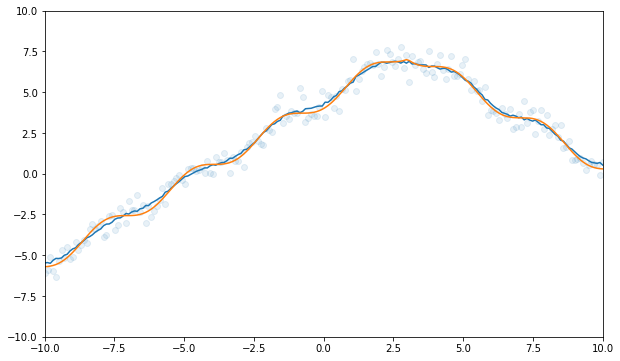

In [56]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.plot(x, y_approx)
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true, alpha=.1)

In [57]:
# projections = np.array([x, np.sin(x), np.cos(x), np.tanh(x)]).T
projections = np.array([x, np.abs(x-2), np.abs(x-5), x-20]).T

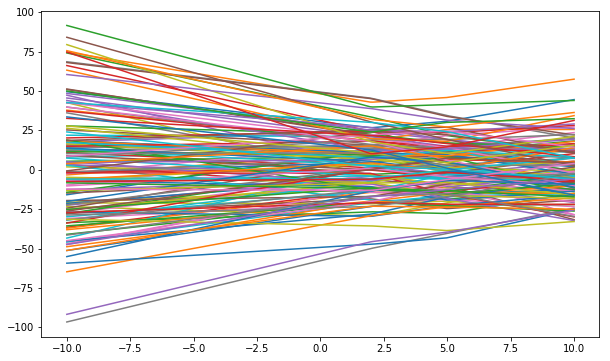

In [58]:
plt.figure(figsize=(10, 6))
# plt.ylim(0, 10)
# plt.xlim(0, 10)
for _ in range(145):
    y = projections @ np.random.randn(4)
    plt.plot(x, y)

In [59]:
# Mean function

n_features = 10
evl = 7  # number of data points at which i want to evaluate

x_new = np.random.randn(evl, n_features)
mu = np.random.randn(10)  # mean of the weights prior

mean_func_eval = x_new @ mu  # the thing we put into the posterior over function evaluations

In [60]:
# Plot some mv-normal draws using an RBF kernel

In [94]:
# def k(xs, ys, sigma=1, l=1):
#     """Sqared Exponential kernel as above but designed to return the whole
#     covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
#     Also with two parameters which are discussed at the end."""

#     # Pairwise difference matrix.
#     dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
#     return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

# def m(x):
#     """The mean function. As discussed, we can let the mean always be zero."""
#     return np.zeros_like(x)